In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 1.获取数据集
data = pd.read_csv("ABtest_actions.csv")
data.head()

,timestamp,id,group,action
0,2016/9/24 17:42,804196,experiment,view
1,2016/9/24 19:19,434745,experiment,view
2,2016/9/24 19:36,507599,experiment,view
3,2016/9/24 19:59,671993,control,view
4,2016/9/24 20:26,536734,experiment,view


In [7]:
# 2. 了解数据总体情况
# 多少条数据：8188
size = len(data)
# 记录去重后的数据集
user_size = len(data['id'].drop_duplicates())
#测试时长:115
days = pd.to_datetime(data['timestamp'].tail(1).values) - pd.to_datetime(data['timestamp'].head(1).values)
print(days)

TimedeltaIndex(['115 days 16:42:00'], dtype='timedelta64[ns]', freq=None)


In [12]:
# # 3. CTR点击率 = 点击用户数 / 浏览用户数（去重后的独立访客数）
# 实现思路：获取对应用户组 groupby/query
# -> 获取点击数、浏览数 -> 去重unique -> 计算点击率
# 方案A：对照组、控制组（control group）
control_group = data.query('group=="experiment"')
control_click = control_group.query('action=="click"')['id'].nunique()
control_view = control_group.query('action=="view"')['id'].nunique()
control_ctr = control_click / control_view


In [13]:
# 方案B：实验组（experiment)
experiment_group = data.query('group=="experiment"')
# print(control_group)
experiment_click = experiment_group.query('action=="click"')['id'].nunique()
experiment_view = experiment_group.query('action=="view"')['id'].nunique()
experiment_ctr = experiment_click / experiment_view

In [14]:
# 方案A的CTR vs 方案B的CTR
diff_ctr = experiment_ctr - control_ctr

In [18]:
# 4. p-value < 0.05
# 4.1 进行抽样调查，进行多次AB实验
diffs = []
for _ in range(10000):
    sample = data.sample(size,replace=True)

    control_group = sample.query('group=="control"')
    control_click = control_group.query('action=="click"')['id'].nunique()
    control_view = control_group.query('action=="view"')['id'].nunique()
    control_ctr = control_click / control_view

    experiment_group = sample.query('group=="experiment"')
    experiment_click = experiment_group.query('action=="click"')['id'].nunique()
    experiment_view = experiment_group.query('action=="view"')['id'].nunique()
    experiment_ctr = experiment_click / experiment_view

    diff = experiment_ctr - control_ctr
    diffs.append(diff)

diffs = np.array(diffs)


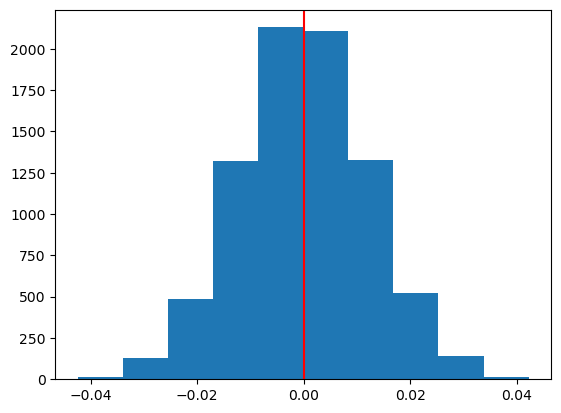

In [20]:
# 4.2 获取差异比例 -> 正态分布模型（0为中心）
normalize_list = np.random.normal(0, diffs.std(), size)
plt.hist(normalize_list)
plt.axvline(x=diff_ctr, color="red")
plt.show()

In [21]:
# 4.3 p值<0.05
p_value = (normalize_list > diff_ctr).mean()
print("p-value：", p_value)
print("p是否<0.05:", p_value < 0.05)

p-value： 0.49865657059110896
p是否<0.05: False
